# Lab 11: Data Analysis and Fourier Transform
## Curve Fitting and Fourier Analysis

1. **Curve fitting** - Finding mathematical models that describe trends in data
2. **Fourier analysis** - Identifying periodic patterns and dominant frequencies

These techniques help us:
- Separate long-term trends from periodic variations
- Extract meaningful patterns from noisy data
- Make predictions based on observed patterns
- Compare simulation results with measurements

---
## Part 1: Polynomial Curve Fitting and Detrending

**What is detrending?** Detrending is the process of removing the long-term trend from data to reveal underlying periodic patterns or variations.

Original Data = Trend + Residuals (detrended data)

### Using numpy.polynomial for fitting trajectories

The example below uses projectile motion data (from the Balle module) to demonstrate polynomial fitting. The trajectory follows a parabolic path, which we can model with a 2nd-degree polynomial: y = a₀ + a₁x + a₂x²

Text(0.5, 1.0, 'Trajectory Data with Air Resistance')

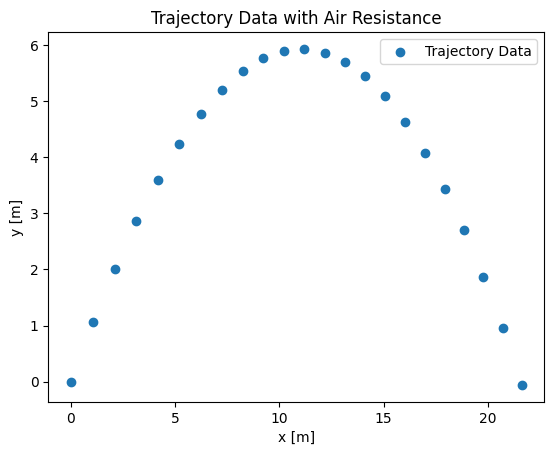

In [1]:
# Problem 5.10: Fit Y(x; a0, a1) = a0*x + a1*x^2 to trajectories from Balle for y0=0. 
# Try different values for initial velocity but keep the initial angle at 45 degrees.
# Include cases where air resistance is significant.
# Determine the largest velocity for which a parabola accurately fits the data.

import numpy as np
import scipy.optimize as spo
import matplotlib.pyplot as plt
import Balle

# Obtain trajectory data for y0 = 0, speed = 15 m/s, angle = 45 degrees, with air resistance
x1, y1 = Balle.traj(0, 15, 45, 0.1, True)

# Create the initial scatter plot of the trajectory data
fig, ax = plt.subplots()
ax.scatter(x1, y1, label='Trajectory Data')  
ax.set_xlabel('x [m]')  
ax.set_ylabel('y [m]')  
ax.legend()  
ax.set_title('Trajectory Data with Air Resistance') 

**What this code does:**
- Uses the `Balle.traj()` function to simulate a projectile trajectory
- Parameters: initial height=0, speed=15 m/s, angle=45°, air resistance included
- Creates a scatter plot to visualize the trajectory data

Note: With air resistance, the trajectory deviates from a perfect parabola, making this a good test for our fitting methods.

### Performing polynomial fit and calculating residuals

- `np.polynomial.polynomial.polyfit(x, y, deg, full=True)` - Fits a polynomial of degree `deg` to the data
  - Returns coefficients `p` and fit statistics in `result`
  - `full=True` provides additional information like sum of squared residuals
- `np.polynomial.polynomial.polyval(x, p)` - Evaluates the polynomial at given x values
- **Residuals** = Data - Fit = How much the model misses by at each point

In [2]:
# Perform polynomial fit (2nd degree) on the trajectory data
p, result = np.polynomial.polynomial.polyfit(x1, y1, 2, full=True)
pfit = np.polynomial.polynomial.polyval(x1, p)
resid = y1 - pfit
print(result)  # Printing fit results
print(resid)  # Printing residuals

[array([0.05495735]), 3, array([1.64980902, 0.51743968, 0.10191361]), 5.10702591327572e-15]
[ 0.10076877  0.04222937 -0.00070791 -0.03022943 -0.04834378 -0.05690116
 -0.05761174 -0.05206312 -0.04173719 -0.02802655 -0.01225037  0.00433022
  0.02049746  0.03506325  0.04685671  0.05471313  0.05746478  0.05393344
  0.04292474  0.02322432 -0.00640449 -0.04722145 -0.10050899]


In [18]:
# Perform polynomial fit (2nd degree) on the trajectory data
p, result = np.polynomial.polynomial.polyfit(x1, y1, 2, full=True)
pfit = np.polynomial.polynomial.polyval(x1, p)
resid = y1 - pfit
print(result)  # Printing fit results
print(resid)  # Printing residuals

[array([0.05495735]), 3, array([1.64980902, 0.51743968, 0.10191361]), 5.10702591327572e-15]
[ 0.10076877  0.04222937 -0.00070791 -0.03022943 -0.04834378 -0.05690116
 -0.05761174 -0.05206312 -0.04173719 -0.02802655 -0.01225037  0.00433022
  0.02049746  0.03506325  0.04685671  0.05471313  0.05746478  0.05393344
  0.04292474  0.02322432 -0.00640449 -0.04722145 -0.10050899]


### Function to fit and plot trajectory with residuals

[-0.10076877  1.10928904 -0.05100368]


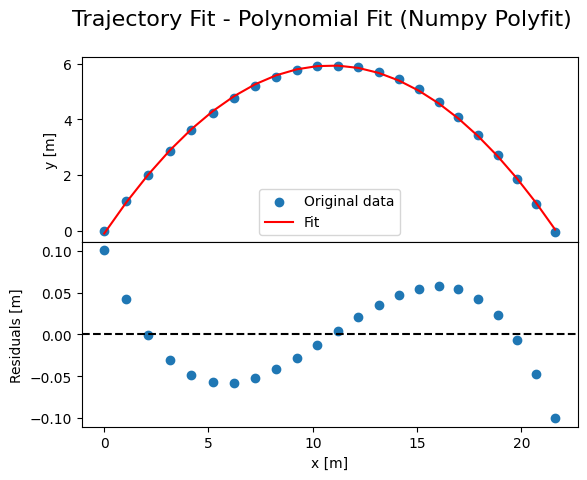

In [3]:
# Function to fit and plot the trajectory
def fit_plot_traj(x, y, fit_type="Polynomial Fit"):
    # Perform the polynomial fit
    p, result = np.polynomial.polynomial.polyfit(x, y, 2, full=True)
    pfit = np.polynomial.polynomial.polyval(x, p)
    resid = y - pfit
    print(p)  # Print polynomial coefficients

    # Plot the original data, fit, and residuals
    fig, ax = plt.subplots(2, 1, sharex=True, gridspec_kw={'hspace': 0})
    fig.suptitle(f'Trajectory Fit - {fit_type}', fontsize=16)  
    ax[0].scatter(x, y, label='Original data')  
    ax[0].plot(x, pfit, label='Fit', color='r')  
    ax[0].set_ylabel('y [m]')  
    ax[0].legend()  

    ax[1].scatter(x, resid, label='Residuals')  # Scatter plot of residuals
    ax[1].axhline(0, color='k', linestyle='--')  # Adding a horizontal line at y=0
    ax[1].set_xlabel('x [m]') 
    ax[1].set_ylabel('Residuals [m]') 

# Obtain new trajectory data for fitting and plotting
x1, y1 = Balle.traj(y0=0, speed=15, theta=45.0, tau=0.1, air_resist=True)
fit_plot_traj(x1, y1, fit_type="Polynomial Fit (Numpy Polyfit)")
plt.show()

**Understanding the two-panel plot:**
- **Top panel:** Shows original data points and the fitted polynomial curve
  - If the fit is good, the red line passes through the center of the data points
- **Bottom panel:** Shows residuals (data - model)
  - Ideally, residuals should be randomly scattered around zero
  - Systematic patterns in residuals indicate the model doesn't capture all features of the data
  - The horizontal dashed line at y=0 helps visualize whether residuals are symmetric

### Alternative: Using scipy.optimize.leastsq for fitting without constant term

Sometimes we know from physics that our model should pass through the origin (no constant term). For example:
- A projectile launched from ground level: y = a₁x + a₂x² (no constant a₀)
- Hooke's Law: F = kx (no offset)

**Scipy's least squares approach:**
- Define the model function: `f(x, a, b) = ax² + bx`
- Define a residual function: `residual(p, x, y) = y - f(x, *p)`
- `scipy.optimize.leastsq()` minimizes the sum of squared residuals
- Requires an initial guess `p0` for the parameters

In [4]:
# Define function for quadratic model
def f(x, a, b):
    return a * x**2 + b * x

# Define residual function for least squares fitting
def residual(p, x, y):
    return y - f(x, *p)

# Initial guess for the parameters a and b
p0 = [1., 1.]
# Perform least squares fit
p = spo.leastsq(residual, p0, args=(x1, y1))
print(p)  # Print optimized parameters
pfit = f(x1, *p[0])

(array([-0.05032923,  1.0912808 ]), 1)


### Updated function with option for constant term

(array([-0.0099978,  1.2863003]), 1)


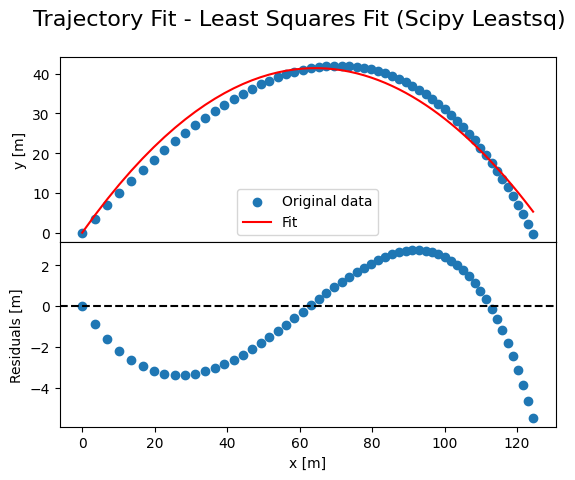

In [5]:
# Updated function to fit and plot the trajectory
def fit_plot_traj(x, y, constant=True):
    # Perform the fit depending on whether a constant term is used
    if constant:
        p, result = np.polynomial.polynomial.polyfit(x, y, 2, full=True)
        pfit = np.polynomial.polynomial.polyval(x, p)
        fit_type = "Polynomial Fit (Numpy Polyfit)"
    else:
        # Perform the polynomial fit, without constant
        p0 = [1., 1.]
        p = spo.leastsq(residual, p0, args=(x, y))
        pfit = f(x, *p[0])
        fit_type = "Least Squares Fit (Scipy Leastsq)"
        
    resid = y - pfit
    print(p)  # Print polynomial coefficients or least squares results

    # Plot the original data, fit, and residuals
    fig, ax = plt.subplots(2, 1, sharex=True, gridspec_kw={'hspace': 0})
    fig.suptitle(f'Trajectory Fit - {fit_type}', fontsize=16)  # Adding title for the figure
    ax[0].scatter(x, y, label='Original data')  # Scatter plot of original data
    ax[0].plot(x, pfit, label='Fit', color='r')  
    ax[0].set_ylabel('y [m]')  
    ax[0].legend()  

    ax[1].scatter(x, resid, label='Residuals')  # Scatter plot of residuals
    ax[1].axhline(0, color='k', linestyle='--')  # Adding a horizontal line at y=0
    ax[1].set_xlabel('x [m]')  
    ax[1].set_ylabel('Residuals [m]')  

# Obtain additional trajectory data for a higher speed
x2, y2 = Balle.traj(y0=0, speed=50, theta=45.0, tau=0.1, air_resist=True)
fit_plot_traj(x2, y2, constant=False)
plt.show()

**Comparing the two methods:**

| Method | Constant Term | Use Case | Function |
|--------|---------------|----------|----------|
| NumPy polynomial | Yes (a₀ + a₁x + a₂x²) | General curve fitting | `np.polynomial.polynomial.polyfit()` |
| SciPy leastsq | No (a₁x + a₂x²) | When model must pass through origin | `scipy.optimize.leastsq()` |

**Testing with higher velocity (50 m/s):**
- At higher speeds, air resistance has a much larger effect
- The trajectory deviates more from a parabola
- This makes it a good test: can our polynomial fit still work?
- Look at the residuals: are they larger? Do they show systematic patterns?

---
## Part 2: Fourier Transform Analysis

**What is Fourier Transform?** 
Fourier Transform decomposes any signal into a sum of sine and cosine waves of different frequencies. For example: A music equalizer showing which frequencies are present in a song

**Why do we use Fourier Transform?**
1. **Identify periodicities** - Find hidden cycles in data (e.g., seasonal CO₂ variations)
2. **Noise filtering** - Separate signal from random noise
3. **Compression** - Store data efficiently by keeping only dominant frequencies
4. **Pattern recognition** - Detect repeating patterns automatically

**Types of Fourier Transforms:**
- **Fourier Transform** - For continuous signals
- **Discrete-time Fourier Transform** - For sampled signals with continuous frequency
- **Discrete Fourier Transform (DFT)** - For sampled signals with discrete frequencies
- **Fast Fourier Transform (FFT)** - Efficient algorithm for computing DFT

**`np.fft.fft()`** computes the DFT using the FFT algorithm. The DFT is the practical version we use for digital/sampled data.

### Example 1: Multiple frequency sine waves

Source: https://pythontic.com/visualization/signals/fouriertransform_fft

In [6]:
# Python example - Fourier transform using numpy.fft method
import numpy as np
import matplotlib.pyplot as plt

### Basic FFT functions

**Three fundamental NumPy FFT functions:**
1. `np.fft.fft(signal)` - Computes the Fast Fourier Transform
   - Input: time-domain signal (array of values)
   - Output: complex numbers representing amplitude and phase at each frequency
   
2. `np.fft.ifft(fft_result)` - Inverse FFT, converts back to time domain
   - Proves FFT is reversible: signal → FFT → IFFT → original signal
   
3. `np.fft.fftfreq(n)` - Generates the frequency values corresponding to FFT output
   - Tells you what frequency each element of the FFT represents

In [7]:
# #The one-dimensional discrete Fourier Transform.
signal = np.array([1.0, 2.0, 1.0, -1.0, 1.5])
fft_result = np.fft.fft(signal)

# #The one-dimensional inverse discrete Fourier Transform.
original_signal = np.fft.ifft(fft_result)

# #The frequencies corresponding to the FFT result
frequencies = np.fft.fftfreq(len(signal))

### Setting up sampling parameters and Aliasing

**Critical concept - Sampling:**
When measuring continuous signals (like sound, temperature, CO₂), we can only measure at discrete time points. This is called sampling.

**Parameters:**
- **Sampling Frequency (100 Hz)** - How many measurements per second
  - Higher sampling frequency = more data points = better resolution
  - But also = more storage, more computation
  
- **Sampling Interval (0.01 s)** - Time between consecutive measurements
  - Sampling Interval = 1 / Sampling Frequency
  
- **Duration (10 seconds)** - How long we record data

**Nyquist-Shannon Sampling Theorem:**
To correctly capture a frequency f, you must sample at least 2f times per second. For example:
- To measure a 7 Hz signal, you need sampling frequency ≥ 14 Hz
- Our 100 Hz sampling can capture frequencies up to 50 Hz

**Aliasing - A Critical Sampling Problem:**

**What is aliasing?** An effect that causes different signals to become indistinguishable when sampled. This happens when you sample too slowly (below the Nyquist rate).

**Example:**
- **Adequately sampled signal:** Sampling at 2× (or more) the signal frequency captures the true oscillation
- **Aliased signal (undersampling):** Sampling below 2× the frequency makes a high-frequency signal look like a different, lower-frequency signal

Reference: https://en.wikipedia.org/wiki/Aliasing

**Visual examples of aliasing:**
See lecture slides!

In [7]:
#Sampling Parameters

# How many time points are needed i,e., Sampling Frequency
samplingFrequency = 100;

# At what intervals time points are sampled
samplingInterval = 1 / samplingFrequency;
 
# Begin time period of the signals
beginTime = 0;

# End time period of the signals
endTime = 10;

### Creating sine waves

In [8]:
#Sine Wave Creation
# Frequency of the signals
signal1Frequency = 4;
signal2Frequency = 7;

# Time points
time = np.arange(beginTime, endTime, samplingInterval);

#Combination of Signals
# Create two sine waves
amplitude1 = np.sin(2*np.pi*signal1Frequency*time)
amplitude2 = np.sin(2*np.pi*signal2Frequency*time)

# Add the sine waves to create combined signal
amplitude = amplitude1 + amplitude2 #this is the signal

### Plotting time-domain signals

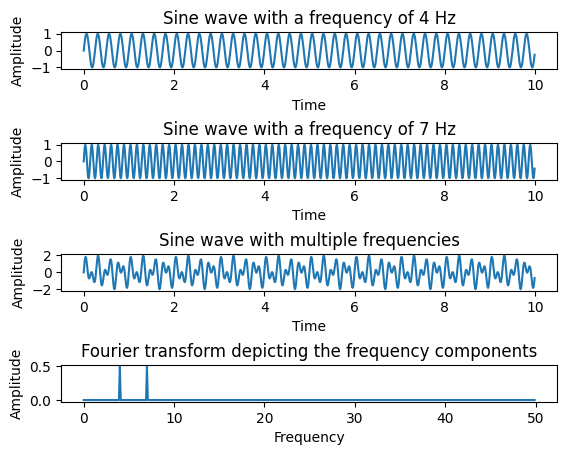

In [9]:
# Create subplot
figure, axis = plt.subplots(4, 1)
plt.subplots_adjust(hspace=2.0)
# Time domain representation for sine wave 1
axis[0].set_title('Sine wave with a frequency of 4 Hz')
axis[0].plot(time, amplitude1)
axis[0].set_xlabel('Time')
axis[0].set_ylabel('Amplitude')
# Time domain representation for sine wave 2
axis[1].set_title('Sine wave with a frequency of 7 Hz')
axis[1].plot(time, amplitude2)
axis[1].set_xlabel('Time')
axis[1].set_ylabel('Amplitude')
# Time domain representation of the resultant sine wave
axis[2].set_title('Sine wave with multiple frequencies')
axis[2].plot(time, amplitude)
axis[2].set_xlabel('Time')
axis[2].set_ylabel('Amplitude')


#Apply FFT
#Normalize the FFT result to scale the amplitudes correctly
# Frequency domain representation
fourierTransform = np.fft.fft(amplitude)/len(amplitude)           # Normalize amplitude
#Extract Frequencies
fourierTransform = fourierTransform[range(int(len(amplitude)/2))] # Exclude sampling frequency
tpCount     = len(amplitude)
values      = np.arange(int(tpCount/2))
timePeriod  = tpCount/samplingFrequency
frequencies = values/timePeriod
#print(abs(fourierTransform))

# Frequency domain representation
axis[3].set_title('Fourier transform depicting the frequency components')
axis[3].plot(frequencies, abs(fourierTransform))
axis[3].set_xlabel('Frequency')
axis[3].set_ylabel('Amplitude')

plt.show()

**From the code above:**

1. **Apply FFT and normalize:**
   - `np.fft.fft(amplitude)` computes the FFT
   - **Division by `len(amplitude)`** normalizes the result
   - Without normalization, amplitude values would depend on signal length

2. **Keep only positive frequencies:**
   - FFT output is symmetric for real-valued signals
   - We only need the first half (positive frequencies)
   - This also excludes the \"sampling frequency\" artifacts

3. **Calculate frequency values:**
   - `tpCount` = total number of data points
   - `timePeriod` = total duration of signal = tpCount / samplingFrequency
   - `frequencies = values / timePeriod` converts indices to actual Hz values

**In the FFT plot:**
There are clear peaks at 4 Hz and 7 Hz - the frequencies we put in!
This demonstrates FFT's power: it automatically finds the frequencies present in any signal.

### Computing power spectrum and finding dominant frequency

In [11]:
#Compute Power Spectrum
powspec = np.abs(fourierTransform**2)
#Find Dominant Frequency
peakfreq= np.argmax(powspec)
print(frequencies[peakfreq])

#the power spectrum is often computed using the discrete Fourier transform (DFT) and its magnitude squared. 
#the power spectrum tells you how the power or energy of a signal is distributed across different frequencies.

7.0


### Computing power spectrum and finding dominant frequency

**Power Spectrum vs. Magnitude Spectrum:**
- **Magnitude spectrum:** `|FFT|` - the absolute value of the FFT
  - Shows the amplitude at each frequency
  
- **Power spectrum:** `|FFT|²` - magnitude squared
  - Shows the energy/power at each frequency
  - More commonly used because:
    - Power is physically meaningful (relates to energy)
    - Emphasizes dominant frequencies (squaring makes peaks more prominent)
    - Reduces noise (small values become even smaller)

**Finding the dominant frequency:**
- `np.argmax(powspec)` finds the index of the maximum value
- `frequencies[peakfreq]` converts that index to actual Hz
- This tells us which frequency has the most energy/power

**Physical interpretation:**
The power spectrum tells you how the signal's energy is distributed across different frequencies.
- High power at a frequency = that frequency is strongly present in the signal
- Low power = that frequency is weak or absent

**For the CO₂ lab:** The dominant frequency will correspond to the period of seasonal variation (1 year = 1/12 months⁻¹)

---
## Part 3: Interactive FFT Demo with User Input

This section lets you experiment with FFT by choosing your own parameters. Try different values to build intuition:

**Examples:**
1. **Vary the frequency:**
   - Try 5 Hz, then 10 Hz, then 20 Hz
   - Notice how the peak in the frequency spectrum moves
   
2. **Vary the phase:**
   - Try phase = 0, then π/2, then π
   - Notice: phase shifts the time-domain signal but doesn't change the frequency spectrum much
   
3. **Vary the number of points:**
   - Try 100, 1000, then 10000 points
   - More points = better frequency resolution (narrower peaks)
   - But also = more computation time

### User-defined parameters for exploring FFT

In [10]:
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt

# User Input for Parameters
N = int(input("Enter the number of points (e.g., 1000): "))  # Number of points in the signal
freq = float(input("Enter the frequency of the sine wave (e.g., 5 Hz): "))  # Frequency of the signal
phase = float(input("Enter the phase of the sine wave (e.g., 0 radians): "))  # Phase of the signal
tau = 1 / 100  # Sampling interval (1/Sampling frequency, e.g., 100 Hz sampling frequency)

Enter the number of points (e.g., 1000):  100
Enter the frequency of the sine wave (e.g., 5 Hz):  5
Enter the phase of the sine wave (e.g., 0 radians):  0


In [11]:
# Time Vector
t = np.arange(N) * tau  # Time vector
# Generate the Signal
y = np.sin(2 * np.pi * freq * t + phase)  # Sine wave with user-defined parameters
# Perform Fourier Transform
yt = np.fft.fft(y)  # Compute the FFT
f = np.fft.fftfreq(N, tau)  # Frequency vector
f_positive = f[:N // 2]  # Positive frequencies
yt_positive = yt[:N // 2]  # FFT values for positive frequencies

# Compute Power Spectrum
power_spectrum = np.abs(yt_positive) ** 2  # Magnitude squared for power

### Plotting results

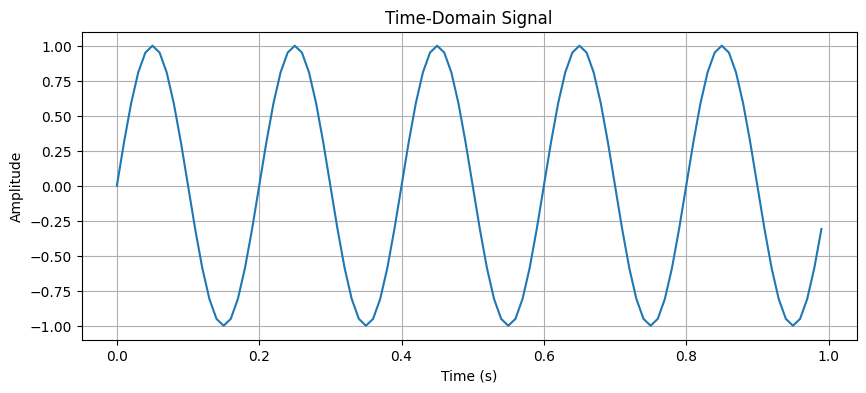

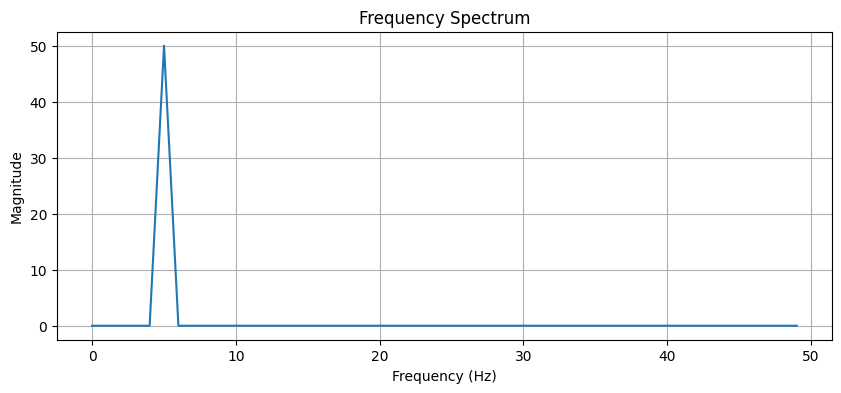

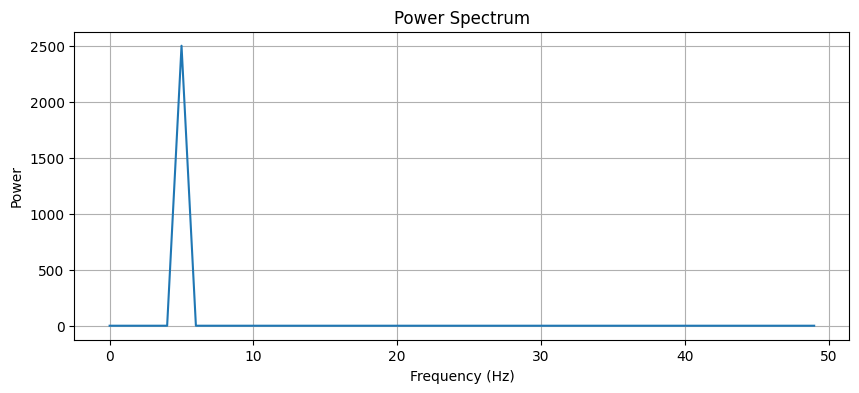

In [12]:
# Plot the Time-Domain Signal
plt.figure(figsize=(10, 4))
plt.plot(t[:100], y[:100])  # Plot the first 100 points for clarity
plt.title("Time-Domain Signal")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.grid()
plt.show()

# Plot the Frequency Spectrum
plt.figure(figsize=(10, 4))
plt.plot(f_positive, np.abs(yt_positive), label="Magnitude")  # Magnitude spectrum
plt.title("Frequency Spectrum")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Magnitude")
plt.grid()
plt.show()

# Plot the Power Spectrum
plt.figure(figsize=(10, 4))
plt.plot(f_positive, power_spectrum)
plt.title("Power Spectrum")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Power")
plt.grid()
plt.show()

### Plotting results
- All three plots should show a clear peak at the frequency you entered
- The peak should be narrow (not spread out)
- There might be small peaks at other frequencies due to numerical effects - ignore these